# The grand canonical ensemble


Given $H$, $P(\infty)$ and $\mu$, calculate
$$
    P(\beta) \approx \Omega(\beta)^{\dagger}\Omega(\beta),
$$
where
$$
    \Omega(\beta) = \exp(-\beta \mathcal{H}_{>}/2) \left( I - \frac{1}{2} \exp(-\beta \mathcal{H}_{>}) 
    \right) ( I - P(\infty))
    + 
    \left( I - \frac{1}{2} \exp(\beta\mathcal{H}_{<}) 
    \right) P(\infty),
$$
$$
    \mathcal{H}_{>} = \frac{1}{2} \{H-\mu I, I - P(\infty)\}, \qquad 
    \mathcal{H}_{<} = \frac{1}{2} \{H-\mu I, P(\infty)\}.
$$

In [1]:
from scipy.io import mmread
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh, norm #, expm

In [2]:
beta = 50

Load matrices in nonorthogonal basis

In [3]:
%ls al

Al128_H.mtx      Al16_H.mtx       Al250_meta.yaml  Al54_meta.yaml
Al128_S.mtx      Al16_S.mtx       Al54_H.mtx
Al128_meta.yaml  Al16_meta.yaml   Al54_S.mtx


In [4]:
matrices_path = "al/"
nono_H = mmread(matrices_path + "Al128_H.mtx")
S = mmread(matrices_path + "Al128_S.mtx")

system = matrices_path.capitalize()[:-1]

Orthogonalize the loaded Hamiltonian to get $H$

In [5]:
def funm_herm(a, func):
    w, v = eigh(a)
    w = func(w)
    return (v * w) @ v.conj().T

isq = funm_herm(S.toarray(), lambda x: -1/np.sqrt(x))

H = isq @ nono_H @ isq

Set chemical potential $\mu$ at half-filling

In [6]:
E = eigh(H, eigvals_only=True)
nel = E.size
mu = E[int(nel/2)-1] + 0.5*(E[int(nel/2)] - E[int(nel/2)-1])

The exact Fermi-Dirac distribution

In [7]:
FD_exact = np.exp(-beta * (E - mu)) / (1 + np.exp(-beta * (E - mu)))

Get the zero temperature state 

In [8]:
P_infty = funm_herm(H, lambda x: (x < mu))

In [9]:
assert np.allclose(P_infty, P_infty @ P_infty), "P_infty is not a projector!"

## Finding minimum polynomial approximation for $\exp$ on the interval $[-1, 0]$

by minimzing
$$
    J = J(a, b, c, d) = \int_{-1}^{0} \left[ \exp(x) - (a + bx + cx^2 + dx^3) \right]^2 dx
$$

In [10]:
import sympy as sp

x, a, b, c, d = sp.symbols('x a b c d')

J = sp.integrate((sp.exp(x) -a - b * x - c * x ** 2 -d * x ** 3)**2, (x, -1, 0)).simplify()

optimal_solution = sp.solve([
    sp.Eq(J.diff(a), 0), sp.Eq(J.diff(b), 0), sp.Eq(J.diff(c), 0), sp.Eq(J.diff(d), 0),
])

J.subs(optimal_solution).evalf()

1.48525005776698e-8

compare the minimal polynomial and exact result 

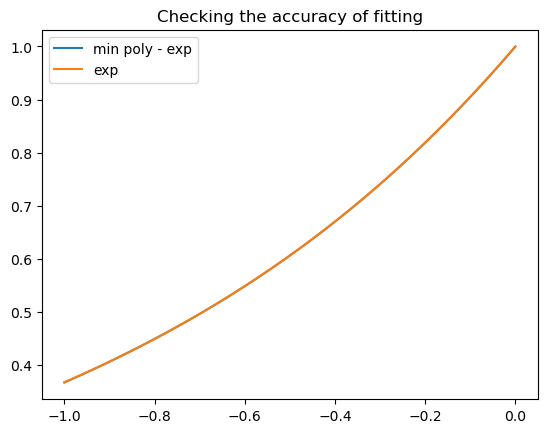

In [11]:
min_poly = sp.lambdify(x, (a + b * x + c * x ** 2 + d * x ** 3).subs(optimal_solution), 'numpy')

xi = np.linspace(-1, 0, 500) 

plt.title("Checking the accuracy of fitting")
plt.plot(xi, min_poly(xi), label="min poly - exp")
plt.plot(xi, np.exp(xi), label="exp")
plt.legend()
plt.show()

In [12]:
[sp.simplify(optimal_solution[_]) for _ in [a, b, c, d]]

[-464 + 1264*exp(-1),
 -5760 + 15660*exp(-1),
 -14700 + 39960*exp(-1),
 -9940 + 27020*exp(-1)]

## Implementing matrix exponentiation via squaring and squaring and minimal polynomial 

In [13]:
def expm_specialized(A):
    
    # scaling
    A_L1 = norm(A, 1)
    
    maxnorm = 1
    n_squarings = max(0, int(np.ceil(np.log2(A_L1 / maxnorm))))
    A = A / 2 ** n_squarings
    
    c = [
        -464 + 1264*np.exp(-1),
        -5760 + 15660*np.exp(-1),
        -14700 + 39960*np.exp(-1),
        -9940 + 27020*np.exp(-1)
    ]
    
    I = np.eye(A.shape[0])
    
    R = c[0] * I  + A @ (c[1] * I + A @ (c[2] * I + A * c[3]))
    
    # how many matrix multiplications it took to get R
    cost_R = 2
    
    # squaring step to undo scaling
    for _ in range(n_squarings):
        R = R @ R
    
    print(f"It took {cost_R + n_squarings} matrix multiplications to get expm")
    
    return R

In [14]:
I = np.eye(H.shape[0])

Get $\mathcal{H}_{>} = \frac{1}{2} \{H-\mu I, I - P(\infty)\}$ and its matrix exponent

In [15]:
def anticommut(a, b):
    return a @ b + b @ a

H_larger = 0.5 * anticommut(H - mu * I, I - P_infty)

# exp_half_H_larger = expm(-0.5 * beta * H_larger)
exp_half_H_larger = expm_specialized(-0.5 * beta * H_larger)

It took 9 matrix multiplications to get expm


Get $\mathcal{H}_{<} = \frac{1}{2} \{H-\mu I, P(\infty)\}$ and its matrix exponent

In [16]:
H_less = 0.5 * anticommut(H - mu * I, P_infty)

# exp_H_less = expm(beta * H_less)
exp_H_less = expm_specialized(beta * H_less)

It took 10 matrix multiplications to get expm


In [17]:
Omega = exp_half_H_larger @ (I - 0.5 * exp_half_H_larger @ exp_half_H_larger) @ (I - P_infty)
Omega += (I - 0.5 * exp_H_less) @ P_infty

P_approx = Omega.conj().T @ Omega

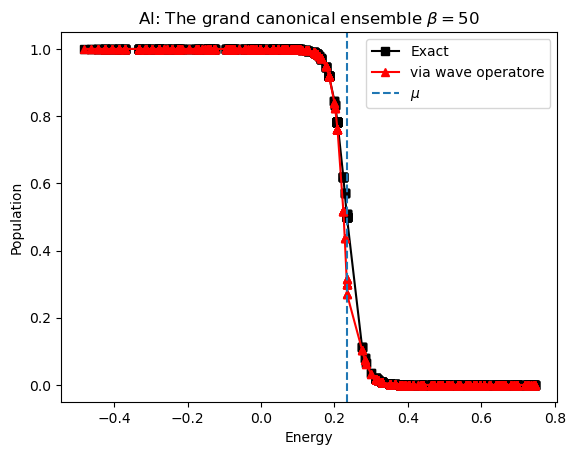

In [18]:
plt.title(f"{system}: The grand canonical ensemble $\\beta = {beta}$")

plt.plot(E, FD_exact, 'ks-', label="Exact")
plt.plot(
    E,
    eigh(P_approx, eigvals_only=True)[::-1],
    'r^-',
    label="via wave operatore"
)
plt.axvline(mu, linestyle='--', label="$\mu$")

plt.xlabel("Energy")
plt.ylabel("Population")
plt.legend(numpoints=1)
plt.savefig(f"results_{system}_beta={beta}.png")
plt.show()